In [1]:
########### Importing all the required libraries
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import zipfile
import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
import sklearn
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df = pd.read_csv("/content/drive/My Drive/data/M5/M5/sales_train_evaluation.csv")
dfcalender = pd.read_csv("/content/drive/My Drive/data/M5/M5/calendar.csv")


In [12]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,d_20,d_21,d_22,d_23,d_24,d_25,d_26,d_27,d_28,d_29,d_30,d_31,d_32,d_33,d_34,...,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d_1914,d_1915,d_1916,d_1917,d_1918,d_1919,d_1920,d_1921,d_1922,d_1923,d_1924,d_1925,d_1926,d_1927,d_1928,d_1929,d_1930,d_1931,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,1,3,0,1,1,1,3,0,1,1,0,0,0,2,0,3,5,0,0,1,1,0,2,1,2,2,1,0,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,2,2,1,2,1,1,1,0,1,1,1,0,0,1,1,0,2,1,0,0,0,0,2,1,3,0,0,1,0,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,0,1,0,5,4,1,0,1,3,7,2,0,0,1,2,4,1,6,4,0,0,0,2,2,4,2,1,1,1,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,2,1,1,0,1,1,2,2,2,4,1,0,2,3,1,0,3,2,3,1,1,3,2,3,2,2,2,2,0,0,0,2,1,0,0,2,1,0


In [13]:
dfcalender.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


Reduce memory usage

In [14]:
#Create date index
date_index = dfcalender['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

In [32]:
###### Creating  DF_Sales dataframe
DF_Sales = df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = df['id'].values
DF_Sales.index = dfcalender.iloc[:1913,0]

In [16]:
DF_Sales.head()

,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_011_CA_1_evaluation,HOBBIES_1_012_CA_1_evaluation,HOBBIES_1_013_CA_1_evaluation,HOBBIES_1_014_CA_1_evaluation,HOBBIES_1_015_CA_1_evaluation,HOBBIES_1_016_CA_1_evaluation,HOBBIES_1_017_CA_1_evaluation,HOBBIES_1_018_CA_1_evaluation,HOBBIES_1_019_CA_1_evaluation,HOBBIES_1_020_CA_1_evaluation,HOBBIES_1_021_CA_1_evaluation,HOBBIES_1_022_CA_1_evaluation,HOBBIES_1_023_CA_1_evaluation,HOBBIES_1_024_CA_1_evaluation,HOBBIES_1_025_CA_1_evaluation,HOBBIES_1_026_CA_1_evaluation,HOBBIES_1_027_CA_1_evaluation,HOBBIES_1_028_CA_1_evaluation,HOBBIES_1_029_CA_1_evaluation,HOBBIES_1_030_CA_1_evaluation,HOBBIES_1_031_CA_1_evaluation,HOBBIES_1_032_CA_1_evaluation,HOBBIES_1_033_CA_1_evaluation,HOBBIES_1_034_CA_1_evaluation,HOBBIES_1_035_CA_1_evaluation,HOBBIES_1_036_CA_1_evaluation,HOBBIES_1_037_CA_1_evaluation,HOBBIES_1_038_CA_1_evaluation,HOBBIES_1_039_CA_1_evaluation,HOBBIES_1_040_CA_1_evaluation,...,FOODS_3_788_WI_3_evaluation,FOODS_3_789_WI_3_evaluation,FOODS_3_790_WI_3_evaluation,FOODS_3_791_WI_3_evaluation,FOODS_3_792_WI_3_evaluation,FOODS_3_793_WI_3_evaluation,FOODS_3_794_WI_3_evaluation,FOODS_3_795_WI_3_evaluation,FOODS_3_796_WI_3_evaluation,FOODS_3_797_WI_3_evaluation,FOODS_3_798_WI_3_evaluation,FOODS_3_799_WI_3_evaluation,FOODS_3_800_WI_3_evaluation,FOODS_3_801_WI_3_evaluation,FOODS_3_802_WI_3_evaluation,FOODS_3_803_WI_3_evaluation,FOODS_3_804_WI_3_evaluation,FOODS_3_805_WI_3_evaluation,FOODS_3_806_WI_3_evaluation,FOODS_3_807_WI_3_evaluation,FOODS_3_808_WI_3_evaluation,FOODS_3_809_WI_3_evaluation,FOODS_3_810_WI_3_evaluation,FOODS_3_811_WI_3_evaluation,FOODS_3_812_WI_3_evaluation,FOODS_3_813_WI_3_evaluation,FOODS_3_814_WI_3_evaluation,FOODS_3_815_WI_3_evaluation,FOODS_3_816_WI_3_evaluation,FOODS_3_817_WI_3_evaluation,FOODS_3_818_WI_3_evaluation,FOODS_3_819_WI_3_evaluation,FOODS_3_820_WI_3_evaluation,FOODS_3_821_WI_3_evaluation,FOODS_3_822_WI_3_evaluation,FOODS_3_823_WI_3_evaluation,FOODS_3_824_WI_3_evaluation,FOODS_3_825_WI_3_evaluation,FOODS_3_826_WI_3_evaluation,FOODS_3_827_WI_3_evaluation
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-29,0,0,0,0,0,0,0,12,2,0,0,0,0,0,4,5,0,0,0,0,0,2,2,0,0,0,0,0,2,0,0,9,0,0,0,2,0,0,0,0,...,0,0,0,0,16,2,1,0,0,0,0,0,36,0,0,0,14,0,0,7,4,0,0,0,0,0,0,0,0,0,0,14,1,0,4,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,15,0,0,0,2,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,12,6,0,0,0,0,0,0,39,0,0,0,7,0,0,6,13,0,0,0,4,0,0,0,0,1,0,11,1,0,4,0,0,6,0,0
2011-01-31,0,0,0,0,0,0,0,0,7,1,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,3,0,0,5,0,0,0,0,0,1,0,0,...,0,0,0,0,11,1,1,0,0,0,0,0,34,0,0,0,6,0,0,9,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,2,0,0,0,0
2011-02-01,0,0,0,0,0,0,0,0,3,0,0,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,1,0,0,...,0,0,0,0,11,3,1,0,0,0,0,0,42,0,0,0,9,0,0,1,1,0,0,0,1,0,0,0,0,1,0,6,1,0,5,2,0,2,0,0
2011-02-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,8,0,0,0,0,0,0,0,0,...,0,0,0,0,6,5,0,0,0,0,0,0,29,0,0,0,0,0,0,6,5,0,0,0,0,0,0,0,0,0,0,5,1,0,2,0,0,2,0,0


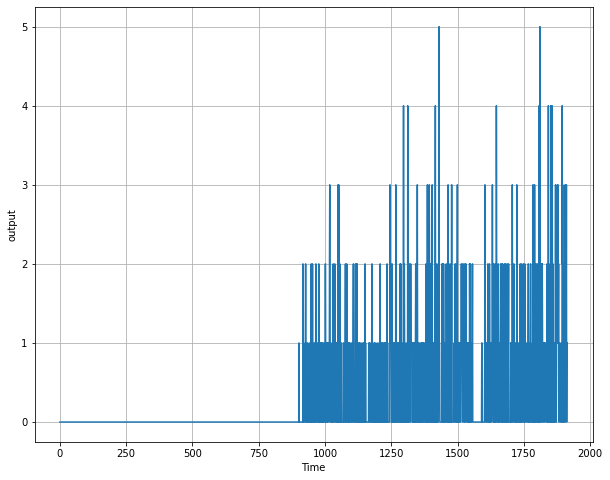

In [17]:
##### selecting multiple time seris using for loop
for i in range(0,1):
  sales = np.array(DF_Sales.iloc[:1913,i])     #### sales time series
  time = np.arange(1,1914)                     #### time range
  plt.figure(figsize=(10, 8))
  plot_series(time, sales)

In [33]:
###### splitiing data for taining and validation
time_range = 1600                             ####### upto 1600 training data
time_train = time[:time_range]                
train = sales[:time_range]
time_valid = time[time_range:]
valid = sales[time_range:]                    ####### validation set after 1600



In [19]:
valid.shape

(313,)

In [34]:
##### Creating function to plot the series
def plot_series(time, sersalesies, format="-", start=0, end=None):
    plt.plot(time[start:end], sales[start:end], format)                    ##### creating plot parameters
    plt.xlabel("Time")                                                     ##### x axis label
    plt.ylabel("output")                                                   ##### y axis 
    plt.grid(True)

In [35]:
### Crating the windowed dataset with the help of tensorflow

def windowed_dataset(sales, window_size, batch_size, shuffle_buffer):
    sales = tf.expand_dims(sales, axis=-1)                             ###### use tf.expand to add extra dimension
    t = tf.data.Dataset.from_tensor_slices(sales)                      ###### get the slices of an array in the form of objects 
    t = t.window(window_size + 1, shift=1, drop_remainder=True)        ####### data is split into chunks of window_size items shifted by
    #######  one value each. This arranges the data in a tabular format. The parameter drop_remainder ensures that all rows in the data window are the same length by cropping data.
    t = t.flat_map(lambda w: w.batch(window_size + 1))                 ####### The data is flattened to make it easier to work with
    t = t.shuffle(shuffle_buffer)                                      
    t = t.map(lambda w: (w[:-1], w[1:]))                               ####### split the data into Xs and Ys; that's features and labe
    return t.batch(batch_size).prefetch(1)                             ####### ####### train our model by sending data in batches.

In [36]:
########## neural network model
tf.keras.backend.clear_session()
tf.random.set_seed(40)
np.random.seed(40)
train_set = windowed_dataset(train, window_size=210, batch_size=100, shuffle_buffer=shuffle_buffer_size)      ####training set
model = tf.keras.models.Sequential([                                 #####groups a linear stack of layers into a
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,                  ##### covolutional layer with 60 filters and relu activation function
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(200, return_sequences=True),                  ######### Long short term memory layers
  tf.keras.layers.LSTM(100, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),        
  tf.keras.layers.Dense(100, activation="tanh"),                       
  tf.keras.layers.Dense(1),                                         #######  A densely-connected neural network layer.
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)          ###### stochastic graient descent optimzer for neural network learning rate 1e-6
model.compile(loss=tf.keras.losses.MeanSquaredError(),              ######  using MeanSquaredError as loss function
              optimizer=optimizer,
              metrics=["mse"])
history = model.fit(train_set,epochs=50)                             ######  training for 50 epoch

Epoch 1/50
14/14 [==============================] - 1s 52ms/step - loss: 4.4287 - mse: 4.4287
Epoch 2/50
14/14 [==============================] - 1s 43ms/step - loss: 4.4789 - mse: 4.4789
Epoch 3/50
14/14 [==============================] - 1s 43ms/step - loss: 1.7623 - mse: 1.7623
Epoch 4/50
14/14 [==============================] - 1s 43ms/step - loss: 1.2225 - mse: 1.2225
Epoch 5/50
14/14 [==============================] - 1s 44ms/step - loss: 0.7158 - mse: 0.7158
Epoch 6/50
14/14 [==============================] - 1s 44ms/step - loss: 0.6890 - mse: 0.6890
Epoch 7/50
14/14 [==============================] - 1s 43ms/step - loss: 0.6316 - mse: 0.6316
Epoch 8/50
14/14 [==============================] - 1s 43ms/step - loss: 0.5985 - mse: 0.5985
Epoch 9/50
14/14 [==============================] - 1s 43ms/step - loss: 0.5681 - mse: 0.5681
Epoch 10/50
14/14 [==============================] - 1s 43ms/step - loss: 0.5442 - mse: 0.5442
Epoch 11/50
14/14 [==============================] - 1s 44m

In [ ]:
##### creating forecast app 
def mforecast(model, sales, window_size):           
    t = tf.data.Dataset.from_tensor_slices(sales)                        ###### get the slices of an array in the form of objects 
    t = t.window(window_size, shift=1, drop_remainder=True)              ###### ####### data is split into chunks of window_size items shifted by
    t = t.flat_map(lambda w: w.batch(window_size))                       ####### The data is flattened to make it easier to work with
    t = t.batch(32).prefetch(1)                                          ####### ####### train our model by sending data in batches.
    forecast = model.predict(t)
    return forecast

In [ ]:
##### forecasting the reamining outcomes
rnn_forecast = mforecast(model, sales[..., np.newaxis], window_size)          
rnn_forecast = rnn_forecast[time_range - window_size:-1, -1, 0]

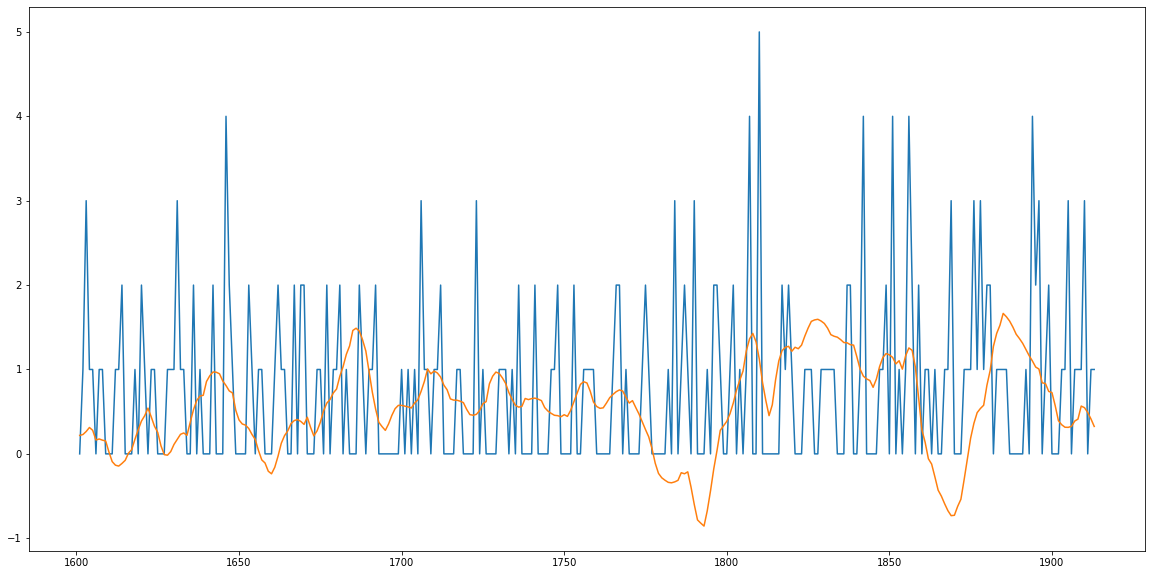

In [ ]:
###### plotting actual values and forecast 
plt.figure(figsize=(20, 10))
plt.plot(time_valid, valid)
plt.plot(time_valid, rnn_forecast)
    

In [ ]:
time_valid.shape, x_valid.shape
time_valid.shape, rnn_forecast.shape

((313,), (313,))

In [ ]:
####### calculate mean absolute error between final forecast and actual values
tf.keras.metrics.mean_absolute_error(valid, rnn_forecast).numpy()


0.8468399

In [ ]:
print(forecast)

In [ ]:
####### calculate mean squarred error between final forecast and actual values
rmse = sqrt(mean_squared_error(valid, rnn_forecast))
print(rmse)

1.0921622949421903


HOLTS WINTERS MODEL

In [ ]:
############# simple holts winter model
fit1 = ExponentialSmoothing(DF_Sales.iloc[:1600,1], seasonal_periods=210, trend='add', seasonal='add').fit()
HOLTSF = fit1.forecast(313)
rmse = sqrt(mean_squared_error(valid, HOLTSF))
print(rmse)


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


1.063745816870731


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


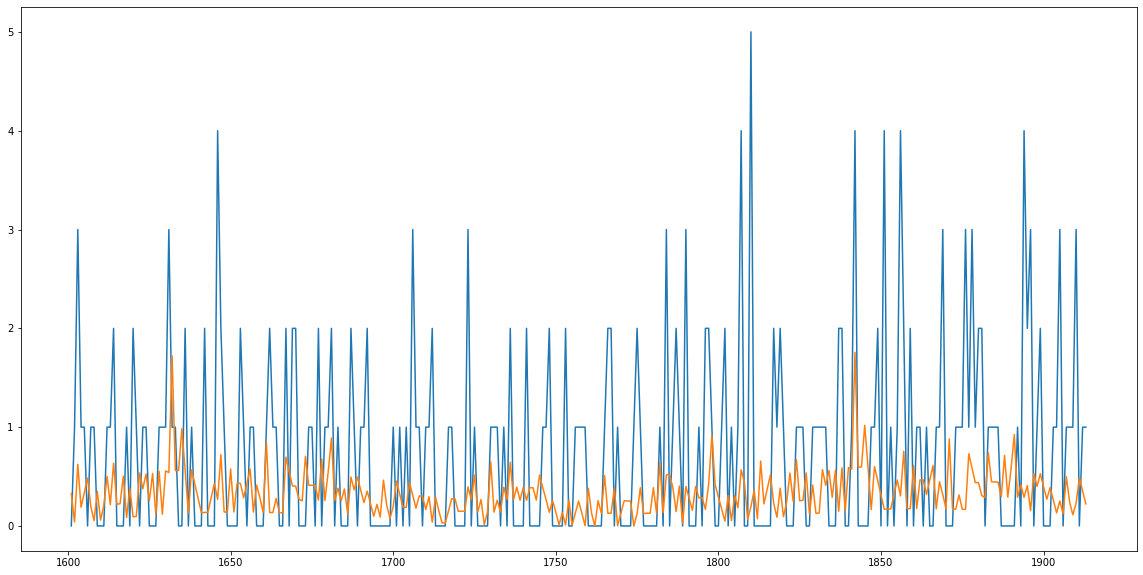

In [ ]:
#### plotiing forcast and actual values
plt.figure(figsize=(20, 10))
plt.plot(time_valid, valid)
plt.plot(time_valid, HOLTSF)